In [37]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import os
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, ReLU
from tensorflow.keras.preprocessing.image import img_to_array, load_img



In [9]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle


In [10]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
!kaggle datasets download julinmaloof/the-oxfordiiit-pet-dataset -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/julinmaloof/the-oxfordiiit-pet-dataset
License(s): CC-BY-SA-4.0
 99% 769M/777M [00:13<00:00, 60.9MB/s]
100% 777M/777M [00:13<00:00, 60.7MB/s]


ValueError: Mismatch between the number of images and trimaps!

# DATA PREPARATION

In [38]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, maps, batch_size, INPUT_DIM, shuffle=False):
        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list = os.listdir(images)
        self.INPUT_DIM = INPUT_DIM
        self.shuffle = shuffle

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.train_image_list) / self.batch_size))

    def __getitem__(self, idx):
        x, y = self.__data_generation(idx)
        y -= 1  # Adjust labels if needed
        return np.array(x), np.array(y)

    def __data_generation(self, idx):
        x = []
        y = []
        for j in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            # Load and preprocess images and maps
            image_path = os.path.join(self.images, os.listdir(self.images)[j])
            map_path = os.path.join(self.maps, os.listdir(self.maps)[j])

            x.append(
                img_to_array(
                    load_img(image_path, target_size=(self.INPUT_DIM, self.INPUT_DIM))
                )
            )
            y.append(
                img_to_array(
                    load_img(
                        map_path,
                        color_mode="grayscale",
                        target_size=(self.INPUT_DIM // 2, self.INPUT_DIM // 2),
                    )
                )
            )

        return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


In [60]:
# import os
# import shutil
# import random

# # Define paths
# train_images = '/content/images/images/'
# train_maps = '/content/annotations/trimaps/'

# train_images_split = '/content/train_images/'
# train_maps_split = '/content/train_maps/'
# val_images_split = '/content/val_images/'
# val_maps_split = '/content/val_maps/'

# # Create directories if they don't exist
# os.makedirs(train_images_split, exist_ok=True)
# os.makedirs(train_maps_split, exist_ok=True)
# os.makedirs(val_images_split, exist_ok=True)
# os.makedirs(val_maps_split, exist_ok=True)

# # Get the list of image files and map files
# image_files = os.listdir(train_images)
# map_files = os.listdir(train_maps)

# # Check if the number of images and maps match
# if len(image_files) != len(map_files):
#     raise ValueError("Mismatch between the number of images and maps!")

# # Shuffle the data to ensure random splitting
# combined_files = list(zip(image_files, map_files))
# random.shuffle(combined_files)

# # Calculate split index
# split_index = int(0.7 * len(combined_files))

# # Split the data into training and validation
# train_data = combined_files[:split_index]
# val_data = combined_files[split_index:]

# # Copy files to the corresponding directories
# def copy_files(data, image_src, map_src, image_dest, map_dest):
#     for image, map_ in data:
#         # Copy images
#         shutil.copy(os.path.join(image_src, image), os.path.join(image_dest, image))
#         # Copy maps
#         shutil.copy(os.path.join(map_src, map_), os.path.join(map_dest, map_))

# # Copy the training and validation data
# copy_files(train_data, train_images, train_maps, train_images_split, train_maps_split)
# copy_files(val_data, train_images, train_maps, val_images_split, val_maps_split)

# print(f"Training data: {len(train_data)} images and maps")
# print(f"Validation data: {len(val_data)} images and maps")


In [80]:
import os
from PIL import Image

image_dir = '/content/images/images/'
map_dir = '/content/annotations/trimaps/'

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # Add more formats if needed

# List of invalid image files
invalid_image_files = []

# Step 1: Identify invalid image files and their corresponding map files
for image_file in os.listdir(image_dir):
    file_ext = os.path.splitext(image_file)[1].lower()
    if file_ext in valid_extensions:
        try:
            img_path = os.path.join(image_dir, image_file)
            img = Image.open(img_path)
            img.verify()  # Verify if the image is corrupted
        except (IOError, SyntaxError) as e:
            print(f"Invalid image file: {image_file}")
            invalid_image_files.append(image_file)  # Add to the list of invalid images
    else:
        print(f"Skipping non-image file: {image_file}")
        invalid_image_files.append(image_file)  # If the file is not an image, mark it as invalid

# Step 2: Remove the invalid image files and their corresponding map files
for invalid_image in invalid_image_files:
    image_path = os.path.join(image_dir, invalid_image)
    map_path = os.path.join(map_dir, os.path.splitext(invalid_image)[0] + '.png')  # Assuming map files are .png

    if os.path.exists(image_path):
        os.remove(image_path)  # Remove invalid image file
        print(f"Removed invalid image: {image_path}")

    if os.path.exists(map_path):
        os.remove(map_path)  # Remove corresponding map file
        print(f"Removed corresponding map: {map_path}")


LR=1e-3
INPUT_DIM=224
NUM_FILTERS=128
BATCH_SIZE=4
EPOCH=100

Skipping non-image file: Abyssinian_101.mat
Skipping non-image file: Abyssinian_102.mat
Skipping non-image file: Abyssinian_100.mat
Removed invalid image: /content/images/images/Abyssinian_101.mat
Removed corresponding map: /content/annotations/trimaps/Abyssinian_101.png
Removed invalid image: /content/images/images/Abyssinian_102.mat
Removed corresponding map: /content/annotations/trimaps/Abyssinian_102.png
Removed invalid image: /content/images/images/Abyssinian_100.mat
Removed corresponding map: /content/annotations/trimaps/Abyssinian_100.png


In [81]:
train_gen = DataGenerator(image_dir,map_dir ,BATCH_SIZE,INPUT_DIM)
# val_gen = DataGenerator(val_images, val_maps,BATCH_SIZE,INPUT_DIM)

# MODELING

In [107]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array


class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_dir, maps_dir, batch_size, input_dim):
        self.images = sorted(os.listdir(images_dir))  # Make sure the list is sorted
        self.maps = sorted(os.listdir(maps_dir))  # Make sure the list is sorted
        self.images_dir = images_dir
        self.maps_dir = maps_dir
        self.batch_size = batch_size
        self.input_dim = input_dim

        # Ensure images and maps have the same number of files
        assert len(self.images) == len(self.maps), "The number of images and maps must be the same"

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch of images and maps
        batch_images = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_maps = self.maps[idx * self.batch_size: (idx + 1) * self.batch_size]

        # Data generation for images and corresponding maps
        x, y = self.__data_generation(batch_images, batch_maps)
        return x, y

    def __data_generation(self, batch_images, batch_maps):
        # Generate data for a batch
        images = []
        maps = []

        for image_file, map_file in zip(batch_images, batch_maps):
            img_path = os.path.join(self.images_dir, image_file)
            map_path = os.path.join(self.maps_dir, map_file)

            # Load image and map
            img = load_img(img_path, target_size=(self.input_dim, self.input_dim))
            map_img = load_img(map_path, target_size=(self.input_dim, self.input_dim))

            # Convert to numpy arrays (optional, based on your requirements)
            images.append(img_to_array(img))
            maps.append(img_to_array(map_img))

        return np.array(images), np.array(maps)


In [108]:
def get_base_model():
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        input_shape=(INPUT_DIM, INPUT_DIM, 3),
        include_top=False,
    )
    base_model.trainable = False

    # Specify the layers to extract outputs
    conv1_relu, conv2_block3_out, conv3_block4_out, conv4_block6_out, conv5_block3_out = [
        base_model.get_layer(layer_name).output
        for layer_name in ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]

    return tf.keras.Model(
        inputs=base_model.inputs,
        outputs=[conv1_relu, conv2_block3_out, conv3_block4_out, conv4_block6_out, conv5_block3_out],
    )

get_base_model().summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [109]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self, NUM_FILTERS):
        super(Upsample, self).__init__()
        self.conv_t_1 = Conv2DTranspose(NUM_FILTERS, 3, strides=2, padding='same', activation='relu')
        self.norm_1 = BatchNormalization()

    def call(self, x):
        x = self.norm_1(self.conv_t_1(x))
        return x


In [110]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self, NUM_FILTERS):
        super(ConvLayers, self).__init__()
        self.conv_1 = Conv2D(NUM_FILTERS * 2, 3, padding='same', activation='relu')
        self.norm_1 = BatchNormalization()
        self.conv_2 = Conv2D(NUM_FILTERS * 4, 3, padding='same', activation='relu')
        self.norm_2 = BatchNormalization()

    def call(self, x):
        x = self.norm_1(self.conv_1(x))
        x = self.norm_2(self.conv_2(x))
        return x


In [111]:
from tensorflow.keras.layers import Concatenate

inputs = tf.keras.Input(shape=(INPUT_DIM, INPUT_DIM, 3))
x = Rescaling(1 / 255.)(inputs)
x_112, x_56, x_28, x_14, x_7 = get_base_model()(x)

x = Upsample(NUM_FILTERS)(x_7)
x = Concatenate(axis=-1)([x, x_14])
x = ConvLayers(NUM_FILTERS)(x)

x = Upsample(NUM_FILTERS)(x)
x = Concatenate(axis=-1)([x, x_28])
x = ConvLayers(NUM_FILTERS)(x)

x = Upsample(NUM_FILTERS)(x)
x = Concatenate(axis=-1)([x, x_56])
x = ConvLayers(NUM_FILTERS)(x)

x = Upsample(NUM_FILTERS)(x)
x = Concatenate(axis=-1)([x, x_112])
x = ConvLayers(NUM_FILTERS)(x)

out = Conv2D(3, 3, padding="same", activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=out)
model.summary()


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_14 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_29             │ [(None, 112, 112, 64), │     23,587,712 │ rescaling_14[0][0]     │
│ (Functional)              │ (None, 56, 56, 256),   │                │                        │
│                           │ (None, 28, 28, 512),   │                │                        │
│                           │ (None, 14, 14, 1024),  │                │                        │
│                           │ (None, 7, 7, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_22 (Upsample)    │ (None, 14, 14, 128)    │      2,359,936 │ functional_29[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20            │ (None, 14, 14, 1152)   │              0 │ upsample_22[0][0],     │
│ (Concatenate)             │                        │                │ functional_29[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_layers_20            │ (None, 14, 14, 512)    │      3,837,696 │ concatenate_20[0][0]   │
│ (ConvLayers)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_23 (Upsample)    │ (None, 28, 28, 128)    │        590,464 │ conv_layers_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 28, 28, 640)    │              0 │ upsample_23[0][0],     │
│ (Concatenate)             │                        │                │ functional_29[0][2]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_layers_21            │ (None, 28, 28, 512)    │      2,658,048 │ concatenate_21[0][0]   │
│ (ConvLayers)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_24 (Upsample)    │ (None, 56, 56, 128)    │        590,464 │ conv_layers_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_22            │ (None, 56, 56, 384)    │              0 │ upsample_24[0][0],     │
│ (Concatenate)             │                        │                │ functional_29[0][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_layers_22            │ (None, 56, 56, 512)    │      2,068,224 │ concatenate_22[0][0]   │
│ (ConvLayers)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_25 (Upsample)    │ (None, 112, 112, 128)  │        590,464 │ conv_layers_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_23            │ (None, 112, 112, 192)  │              0 │ upsample_25[0][0],     │
│ (Concatenate)        

 Total params: 37,922,691 (144.66 MB)

 Trainable params: 14,327,811 (54.66 MB)

 Non-trainable params: 23,594,880 (90.01 MB)

# TRAINING

In [112]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=Adam(learning_rate=LR),
    metrics=['accuracy'],  # Wrap the metric in a list
    run_eagerly=True,
)


In [113]:
import tensorflow as tf
import numpy as np

class StopOnIndexError(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if logs and 'loss' in logs and np.isnan(logs['loss']):
            print(f"Stopping training due to IndexError or invalid loss in batch {batch}.")
            self.model.stop_training = True


In [114]:
history = model.fit(
    train_gen,
    verbose=1,
    shuffle=True,
    epochs=5,
    steps_per_epoch=100,
    callbacks=[StopOnIndexError()]
)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6122 - loss: 1.1694
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.6873 - loss: 0.8099
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6966 - loss: 0.7636
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6994 - loss: 0.7549
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6985 - loss: 0.7487


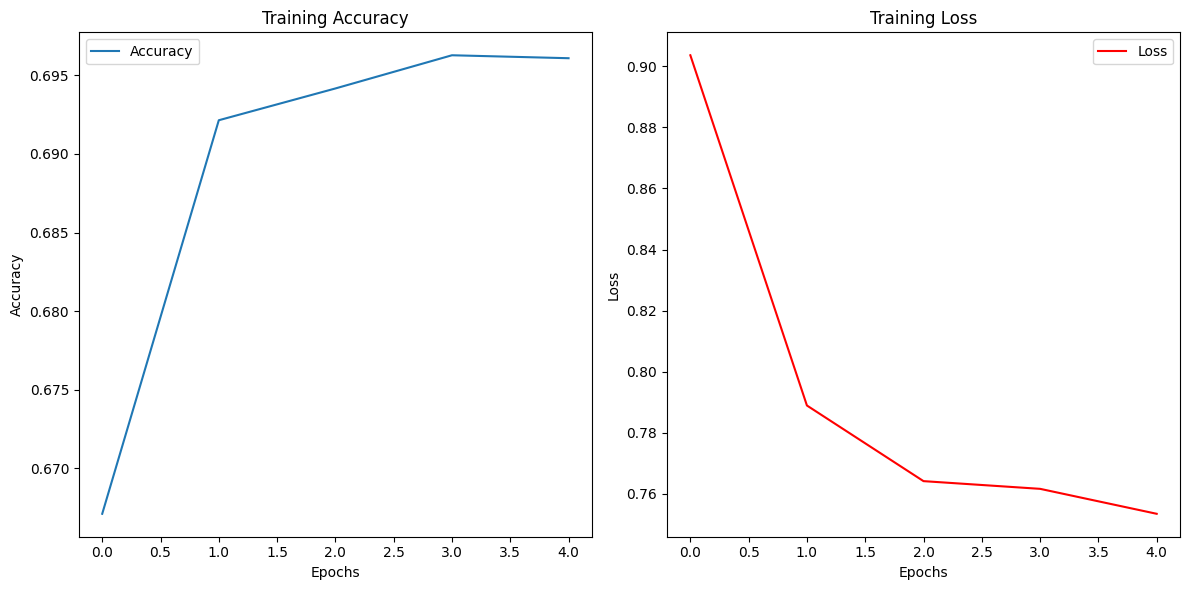

In [115]:
# Plotting the training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# TESTING

In [118]:
test_image ='/content/images/Abyssinian_1.jpg'
test_image_map='/content/annotations/trimaps/Abyssinian_1.png'

X=[]
X.append(img_to_array(load_img(test_image,target_size=(224,224))))
image_output=tf.argmax(model.predict(tf.constant(X)),axis=-1)[0]
image_output=tf.expand_dims(image_output,axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


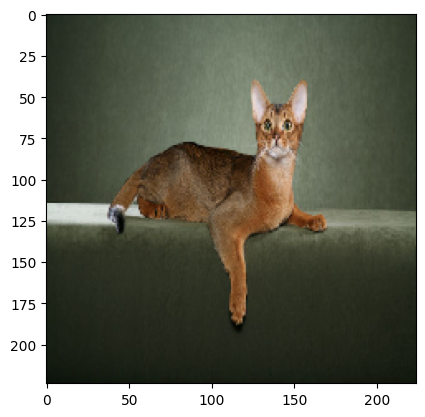

In [119]:
image=tf.keras.preprocessing.image.load_img(test_image,color_mode='rgb',target_size=(224,224))
plt.imshow(image)
plt.show()

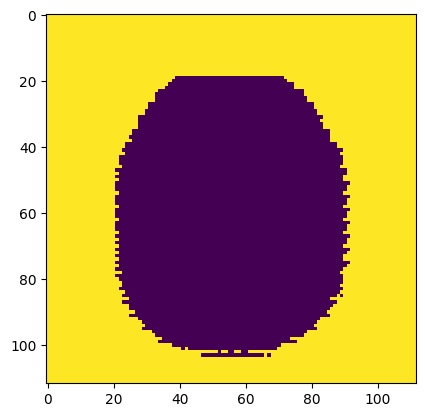

In [120]:
plt.imshow(image_output[...,0])
plt.show()